Source : https://www.kaggle.com/c/quora-question-pairs

 Problem Statement

Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

<b>Real world/Business Objectives and Constraints</b> <br>
The cost of a mis-classification can be very high.<br>
You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.<br>
No strict latency concerns.<br>
Interpretability is partially important.<br>

 Data Overview
- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
# import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Reading data and basic stats

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/quora_casestudy/train.csv')

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#Distribution of data points amonf output class

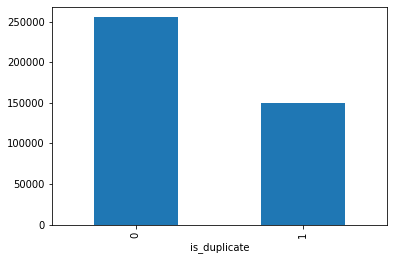

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('Total number of question pair for traing {}'.format(len(df)))
print("Question pairs are not simlars (is_dulicate=0):\n  {}%".format(100-round(df['is_duplicate'].mean()*100,2)))
print("Question pairs are not simlars (is_dulicate=0):\n  {}%".format(round(df['is_duplicate'].mean()*100,2)))

Total number of question pair for traing 404290
Question pairs are not simlars (is_dulicate=0):
  63.08%
Question pairs are not simlars (is_dulicate=0):
  36.92%


#number of unique questions

In [ ]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs=len(np.unique(qids))
qs_morethan_onetime=np.sum(qids.value_counts()>1)
print("Toral unique questions are : {}\n".format(unique_qs))
print("number of questions that appear more than one time{} ({}%)\n".format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print("Max number of times a single questions is repeted:{}\n".format(max(qids.value_counts())))

Toral unique questions are : 537933

number of questions that appear more than one time111780 (20.77953945937505%)

Max number of times a single questions is repeted:157



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



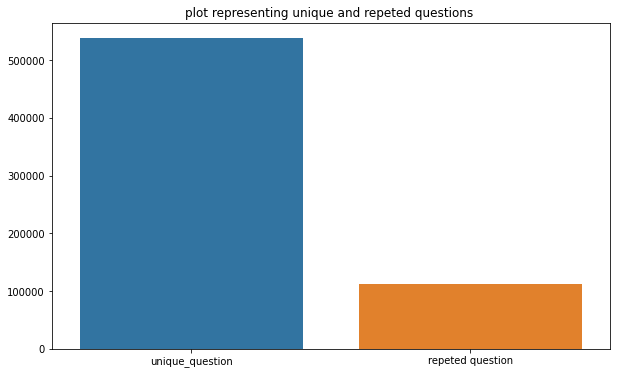

In [ ]:
x=["unique_question","repeted question"]
y=[unique_qs,qs_morethan_onetime]

plt.figure(figsize=(10,6))
plt.title("plot representing unique and repeted questions ")
sns.barplot(x,y)
plt.show()

#check for duplicate pairs

In [ ]:
pair_duplicate=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("number of duplicate questions",(pair_duplicate).shape[0]-df.shape[0])

number of duplicate questions 0


 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



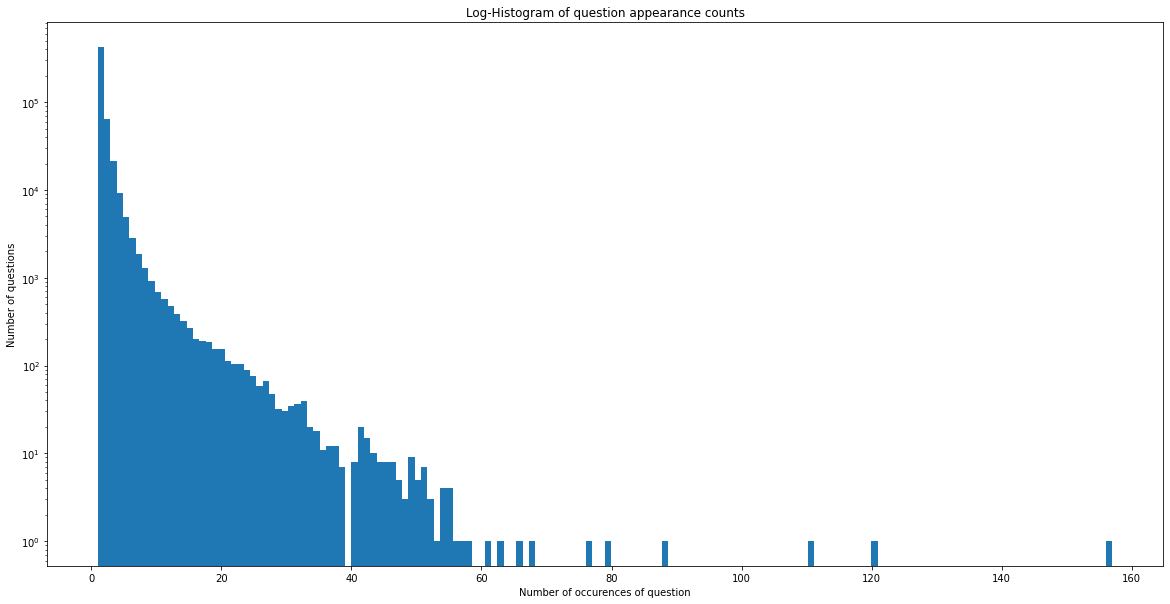

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

#check for null values

In [ ]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


In [ ]:
#fill null value with ''
df=df.fillna('')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


#Basic feature extraction

Let us now construct a few features like:
freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [ ]:
if os.path.isfile('/content/drive/MyDrive/quora_casestudy/df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("/content/drive/MyDrive/quora_casestudy/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

Minimum length of the questions in question1 :  1


In [ ]:
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

Minimum length of the questions in question2 :  1


In [ ]:
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


#Feature word share

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



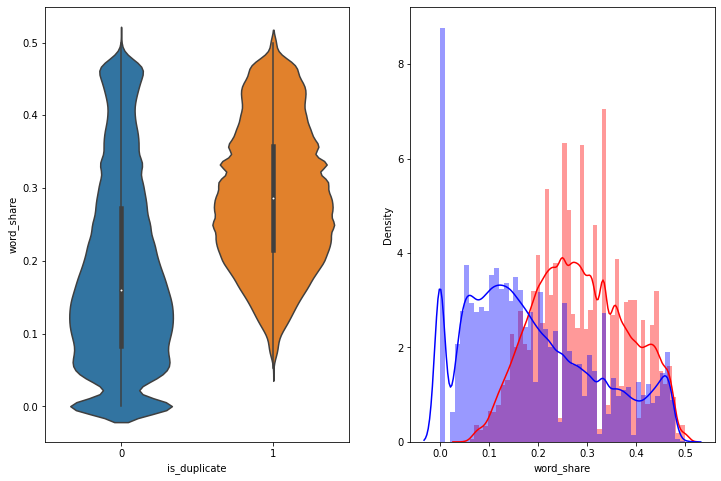

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

#feature : word_common

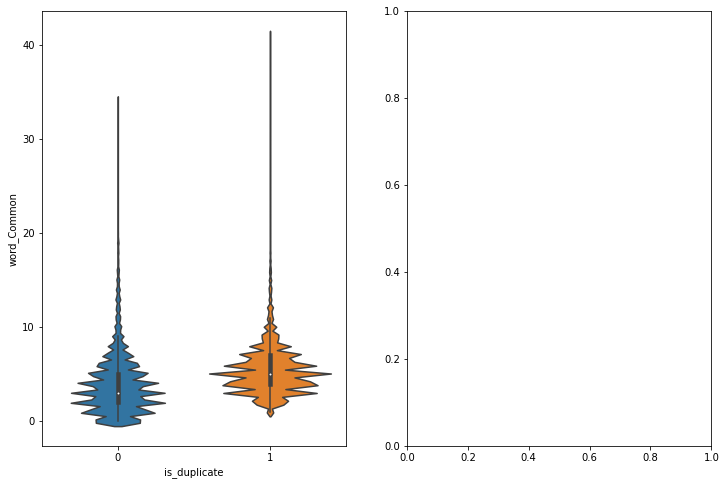

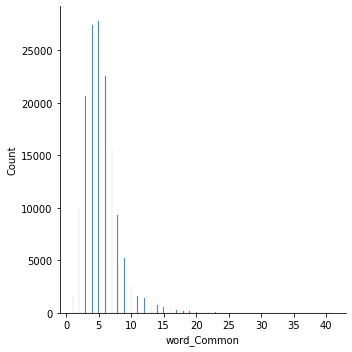

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=df[0:])

plt.subplot(1,2,2)
sns.displot(df[df['is_duplicate']==1.0]['word_Common'])

#preprocessing text<br>
Removing html tags

1.   Removing Punctuations
2.   Performing stemming
3.Removing Stopwords
4.Expanding contractions etc.








In [ ]:
#to get the result in 4 decimal points 
import nltk
nltk.download('stopwords')

# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W') #rempve special charecters 
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Advance Feature Engineering

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1,q2):
  token_features=[0.0]*10
  #converting the sentence into tokens:
  q1_tokens=q1.split();
  q2_tokens=q2.split();

  if len(q1_tokens)== 0 or len(q2_tokens) ==0:
    #Get non stop words in question
    q1_words=set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words=set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #get stopwords
    q1_stops=set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops=set([word for word in q2_tokens if word in STOP_WORDS])

    #get the common non stopwords from Question pair 
    common_word_count=len(q1_words.intersection(q2_words))

    #get the common stopwords from Question pairs
    common_stop_count=len(q1_stops.intersection(q2_stops))

    #get the common tokens from question pair 
    common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[1]=common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[2]=common_stop_count/(min(len(q1_stops),len(q2_stops))+SAFE_DIV)
    token_features[3]=common_stop_count/(max(len(q1_stops),len(q2_stops))+SAFE_DIV)
    token_features[4]=common_token_count/(min(len(q1_tokens),len(q2_tokens))+SAFE_DIV)
    token_features[5]=common_token_count/(max(len(q1_tokens),len(q2_tokens))+SAFE_DIV)

    #last word is equal or not 
    token_features[6]=int(q1_tokens[-1]==q2_tokens[-1])

    #first word is equal or not 
    token_features[7]=int(q1_tokens[0]==q2_tokens[0])

    token_features[8]=abs(len(q1_tokens)-len(q2_tokens))

    #average token length 
    token_features[9]=(len(q1_tokens)+len(q2_tokens))/2
    return token_features

#get the longest common sub string 
def get_longest_substr_ratio(a,b):
  strs=list(distance.lcsubstrings(a,b))
  if len(strs) == 0 :
    return 0
  else:
    return len(str[0])/(min(len(a),len(b))+1)


In [ ]:
pip install fuzzywuzzy


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
def extract_features(df):
  #preprocessing each questions
  df["question1"]=df["question1"].fillna("").apply(preprocess)
  df["question2"]=df["question2"].fillna("").apply(preprocess)
  print("Token features ...")

  #merging featre with datset
  token_features=df.apply(lambda x:get_token_features(x["question1"],x["question2"]),axis=1)
  df["cwc_min"]=list(map(lambda x: x[0],token_features))
  df['cwc_max']=list(map(lambda x: x[1],token_features))
  df['csc_min']=list(map(lambda x: x[2],token_features))
  df['csc_max']=list(map(lambda x: x[3],token_features))
  df['ctc_min']=list(map(lambda x: x[4],token_features))
  df['ctc_max']=list(map(lambda x: x[5],token_features))
  df['last_word_eq']=list(map(lambda x: x[6],token_features))
  df['first_word_eq']=list(map(lambda x: x[7],token_features))
  df['abs_len_diff']=list(map(lambda x: x[8],token_features))
  df['first_word_eq']=list(map(lambda x: x[7],token_features))
  df['mean_len']=list(map(lambda x: x[9],token_features))

  #computing fuzzy features and merging with the data set 
  print("fuzzy features ..")
  df['token_set_ratio']=df.apply(lambda x:fuzz.token_set_ratio(x['question1'],x['question2']),axis=1)
  df['token_sort_ration']=df.apply(lambda x:fuzz.token_sort_ratio(x['question1'],x['question2']),axis=1)
  df['fuzz_ratio']=df.apply(lambda x:fuzz.QRatio(x['question1'],x['question2']),axis=1)
  df['fuzz_partial_ratio']=df.apply(lambda x:fuzz.partial_ratio(x['question1'],x['question2']),axis=1)
  df['longest_substr_ratio']=df.apply(lambda x:fuzz.QRatio(x['question1'],x['question2']),axis=1)
  return df


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
if os.path.isfile('/content/drive/MyDrive/quora_casestudy/nlp_features_train.csv'):
  df=pd.read_csv('/content/drive/MyDrive/quora_casestudy/nlp_features_train.csv',encoding='latin-1')
  df.fillna('')
else:
  print("Extracting features : ");
  df=pd.read_csv("/content/drive/MyDrive/quora_casestudy/train.csv")
  df=extract_features(df1)
  df.to_csv("/content/drive/MyDrive/quora_casestudy/nlp_features_trainMy.csv")
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


#Analysys of extracted features

##plotting the word cloud
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [ ]:
df_duplicate=df[df['is_duplicate']==1]
df_nonduplicate=df[df['is_duplicate']==0]
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p=np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n=np.dstack([df_nonduplicate['question1'],df_nonduplicate['question2']]).flatten()

print("number of data points in class 1 (duplicate pairs) :",len(p))
print("number of data points in class 0 (non duplicate pairs :",len(n))

#saving the np array into text file
np.savetxt('/content/drive/MyDrive/quora_casestudy/train_myP.txt',p,delimiter=' ',fmt='%s')
np.savetxt('/content/drive/MyDrive/quora_casestudy/train_myn.txt',n,delimiter=' ',fmt='%s')


number of data points in class 1 (duplicate pairs) : 298526
number of data points in class 0 (non duplicate pairs : 510054


In [ ]:
#reading text files and removing the stop words
from os import path

d=path.dirname('.')
textp_w=open(path.join(d,'/content/drive/MyDrive/quora_casestudy/train_myP.txt')).read()
textn_w=open(path.join(d,'/content/drive/MyDrive/quora_casestudy/train_myn.txt')).read()
stopwords=set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("like")
print("Total number of words in duplicate pair questions:" ,len(textp_w))
print("Total number of words in non duplicate pair questions",len(textn_w))

Total number of words in duplicate pair questions: 16109886
Total number of words in non duplicate pair questions 33193130


__word cloud generated from duplicate pair questions text __

Word cloud for duplicate question pairs


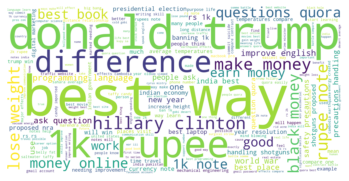

In [ ]:
# wc = Wordcloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
from wordcloud import WordCloud 

wordcloud=WordCloud(background_color='white',mode="RGB", width=2000 , height=1000).generate(textp_w) 

# wc.generate(textp_w)
print("Word cloud for duplicate question pairs")
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud for duplicate question pairs


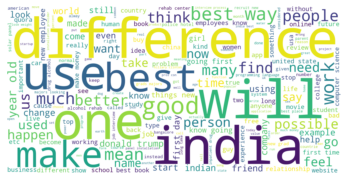

In [ ]:
wordcloud=WordCloud(background_color='white',mode="RGB", width=2000 , height=1000).generate(textn_w) 

# wc.generate(textn_w)
print("Word cloud for duplicate question pairs")
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

pair plot of features ['ctc_min','cwc_min','csc_min','token_sort_ratio','is_duplicate']

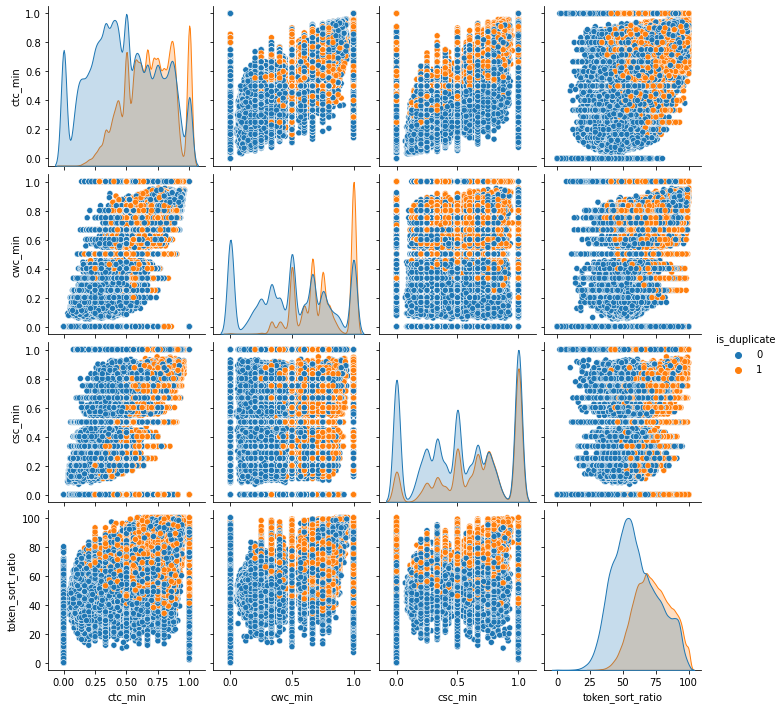

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



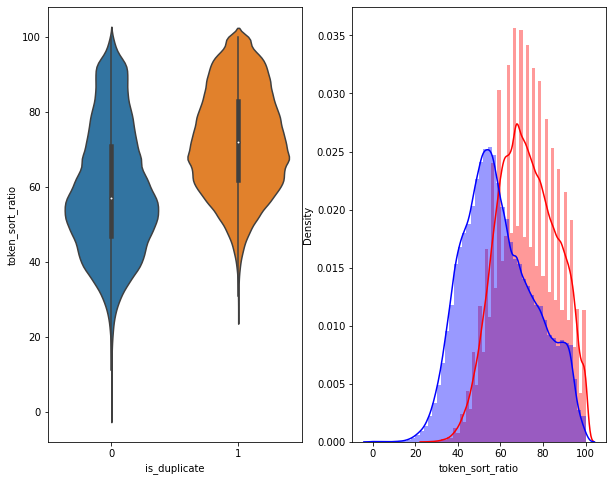

In [ ]:
#Distribution of token sort ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



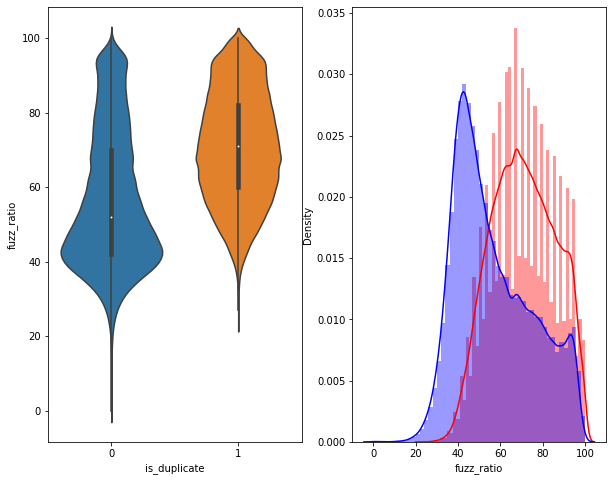

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#Visualization


In [ ]:
#Using TSNE for Diamentionality reduction for 15 Features(Generated after cleaning the data ) to 3 diamention
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
dfp_subsampled=df[0:5000]
X=MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y=dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d=TSNE(n_components=2,init='random',random_state=101,method='barnes_hut',n_iter=1000,
            verbose=2,
            angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.318s
[t-SNE] Iteration 50: error = 80.9634247, gradient norm = 0.0451379 (50 iterations in 2.396s)
[t-SNE] Iteration 100: error = 70.4310913, gradient norm = 0.0098959 (50 iterations in 1.712s)
[t-SNE] Iteration 150: error = 68.6403122, gradient norm = 0.0059423 (50 iterations in 1.710s)
[t-SNE] Iteration 200: error = 67.7985153, gradient norm = 0.0040715 (50 iterations in 1.782s)
[t-SNE] Iteration 250: error = 67.3001938, gradient norm = 0.0031636

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



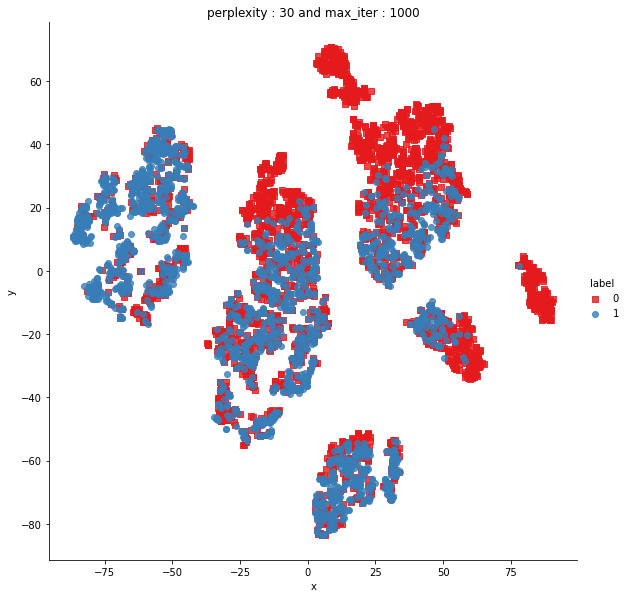

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



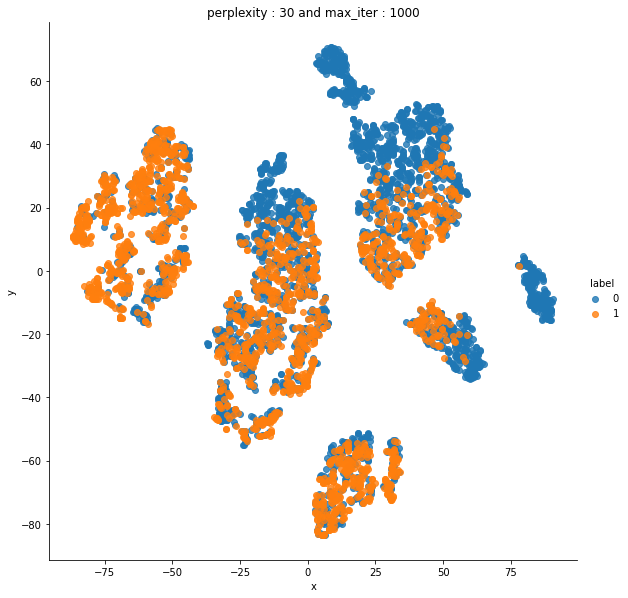

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8)
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
# avoid decoding problems
df=pd.read_csv('/content/drive/MyDrive/quora_casestudy/train.csv')
df['question1']=df['question1'].apply(lambda x:str(x))
df['question2']=df['question2'].apply(lambda x:str(x))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score

word2tfidf=dict(zip(tfidf.get_feature_names(),tfidf.idf_))

In [ ]:
pip install spacy

In [ ]:
import spacy


In [ ]:
from tqdm import tqdm

from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')

vecs1=[]
for qu1 in tqdm(list(df['question1'])):
  doc1=nlp(qu1)
  mean_vec1=np.zeros([len(doc1),len(doc1[0].vector)])
  for word1 in doc1:
    #w2v
    vec1=word1.vector
    #fetch df score
    try:
      idf=word2tfidf[str(word1)]
    except:
      idf=0
    #compute final vec 
    mean_vec1+=vec1*idf
  mean_vec1=mean_vec1.mean(axis=0)
  vecs1.append(mean_vec1)
df['q1_feats_m']=list(vecs1)

100%|██████████| 404290/404290 [1:11:23<00:00, 94.39it/s]


In [ ]:
from tqdm import tqdm

from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')

vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:14:02<00:00, 91.00it/s]


In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_feats_m', 'q2_feats_m'],
      dtype='object')

In [ ]:
if os.path.isfile('/content/drive/MyDrive/quora_casestudy/nlp_features_train.csv'):
  dfnlp=pd.read_csv('/content/drive/MyDrive/quora_casestudy/nlp_features_train.csv',encoding='latin-1')
else:
  print("download nlp_feature.cvs from drive")

if os.path.isfile('/content/drive/MyDrive/quora_casestudy/df_fe_without_preprocessing_train.csv'):
  dfppro=pd.read_csv("/content/drive/MyDrive/quora_casestudy/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
  print("downlod de_fe_without_preprocessing_train.csv frpm drive ")

In [ ]:
dfnlp.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [ ]:
dfppro.columns


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
#data frame of nlp features
df1.head()


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [ ]:
#data before pre processing 
df2.head()


,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
#Question 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,-6.179507,37.450731,-67.929894,32.224274,143.348826,135.374574,17.865208,54.562352,81.618936,232.909839,27.167002,-6.187220,41.996069,-103.537911,-6.616976,-94.064813,-31.617267,-29.205890,-39.608413,30.163852,67.357976,56.346944,7.606743,20.720049,-56.899175,-41.419606,30.634747,-20.667785,93.049776,-108.506989,134.494691,-69.708587,57.891030,-94.501012,-34.043306,-88.044590,197.875458,-56.918224,-33.153865,-68.587951,...,114.638685,50.816876,-57.381595,106.554903,98.567380,-67.311119,88.728154,48.158799,-12.962363,-108.238607,77.740890,-76.930486,-55.488544,55.403322,-134.602412,15.887729,-14.812700,-43.172916,-71.213891,66.473449,138.864320,-134.555638,11.072384,11.770594,23.349589,-83.244351,-55.722126,-21.893210,8.263763,-14.915859,-71.834689,-60.222858,-22.026407,103.336720,-68.477445,-54.976584,-67.802663,116.269999,60.515897,-12.245916
1,9.236668,-80.371416,-45.785907,78.291656,183.568221,100.894077,74.344804,48.360802,127.297421,112.987302,73.449294,-47.164479,31.560610,-77.927155,-103.803116,-78.503396,11.997354,73.522302,-3.368269,-61.134586,1.137853,-47.250332,-14.747230,-111.214488,-92.936345,-86.908993,26.479862,-125.349442,53.630314,-118.244944,-19.311728,4.184269,37.147654,-32.207492,54.693156,-146.564649,190.351235,-50.185377,-102.660014,-62.070884,...,69.116646,123.042798,2.978409,-52.171842,-77.587376,-43.825259,-2.570918,25.001977,74.528037,55.402768,53.763126,-27.621300,-62.024373,67.296625,-127.672300,5.919581,51.888908,5.646263,-52.011487,-22.036677,150.269148,-19.587007,-46.445237,-12.489538,104.020920,-83.863392,-11.340908,26.339330,16.131961,137.782501,-32.130515,-98.080325,19.113790,-20.507508,-76.981011,82.665075,41.085582,129.377781,115.868467,4.383543
2,97.546829,22.972195,-39.558378,18.723416,56.928620,48.307643,8.719268,36.893737,106.899948,226.283080,-5.023025,-68.019793,-52.865684,-112.794187,49.411453,4.386397,-23.508985,3.867846,-19.287308,-52.332033,59.900114,102.718565,-6.070379,-47.957186,-51.316635,26.235306,-71.297170,-82.694041,61.166595,-59.661620,85.192997,95.725261,-9.786940,-44.572019,-26.737537,-8.913334,67.037574,-85.818559,-137.332815,-58.704829,...,126.969506,32.991508,11.751381,32.921630,127.876085,-117.452091,-53.697893,116.449840,-7.114503,-28.417017,22.236688,-95.365500,-13.684289,67.952175,-19.670386,0.049363,63.119457,21.524016,-36.342319,7.531785,101.659882,-90.213289,-11.944407,-20.185547,16.732628,9.608647,-77.976104,77.923826,59.257286,-78.643996,-66.835015,87.592131,4.032431,56.851709,-43.625410,-57.580963,-50.425829,78.591986,105.714348,-33.304161
3,57.586999,-22.017088,-4.599304,-88.939273,-4.732172,-54.209038,74.614942,106.533731,15.520623,39.009711,-101.132338,-12.242595,148.377723,101.759336,61.735411,147.720951,-76.666564,-61.303286,-63.827246,8.319557,-32.426865,-6.724337,-28.032162,-32.440859,25.425998,125.724761,5.593011,-111.110888,-10.119862,-23.430039,-38.038687,-19.025249,38.910990,-52.249356,-13.859811,-56.759533,19.452093,-96.299227,-86.240144,18.250540,...,99.160310,22.281756,-18.003228,20.443845,17.556030,-152.605936,-27.253293,2.113273,9.557493,-13.790257,-97.305417,11.291192,71.311880,20.816198,-23.316110,-17.823973,48.085230,30.902770,-5.960159,-99.039773,125.188415,-17.051089,-43.028228,79.045821,37.998520,-86.332762,-23.401571,55.163438,-13.930802,-25.005486,28.362956,41.981221,-11.204984,16.833434,-36.372471,8.927573,-64.553194,95.054238,-34.157566,70.821932
4,83.185784,-40.506985,-83.403923,-52.648658,79.074884,-19.038248,53.728722,97.648612,160.555822,290.541356,48.316273,28.484493,157.912918,-71.539273,62.088563,51.716923,-82.084056,-35.192773,-53.508376,-53.804667,124.787429,5.007129,-58.838039,-17.581073,-89.628781,21.836286,7.694493,-164.066897,159.268660,-92.885525,63.914158,82.922555,54.042456,-58.458466

In [ ]:
#question 2 tfidf weighted word2vec
df3_q2.head()

,0
0,112657.093750
1,112659.687500
2,112660.773438
3,112661.906250
4,112663.523438


In [ ]:
print("Number of features in nlp dataframe:",df1.shape[1])
print("Number of features in preprocessed dataframe:",df2.shape[1])
print("Number of features in question1 w2v dataframe :",df3_q1.shape[1])
print("Number of features in question2 w2v dataframe :",df3_q2.shape[1])
print("Number of features in final dataframe :",df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe: 17
Number of features in preprocessed dataframe: 12
Number of features in question1 w2v dataframe : 96
Number of features in question2 w2v dataframe : 1
Number of features in final dataframe : 126


In [ ]:
#storing the final feature to csv file
if not os.path.isfile('/content/drive/MyDrive/quora_casestudy/final_features.csv'):
  df3_q1['id']=df1['id']
  df3_q2['id']=df1['id']
  df1=df1.merge(df2,on='id',how='left')
  df2=df3_q1.merge(df3_q2,on='id',how='left')
  result=df1.merge(df2,on='id',how='left')
  result.to_csv('/content/drive/MyDrive/quora_casestudy/final_features.csv')


In [ ]:
pip install patool


     |████████████████████████████████| 77 kB 3.4 MB/s 


In [ ]:
!unrar x "/content/drive/MyDrive/quora_casestudy/final_features.rar" "/content/drive/MyDrive/quora_casestudy/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/quora_casestudy/final_features.rar

Extracting  /content/drive/MyDrive/quora_casestudy/final_features.csv       0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 9

#ml MODELS


##Reading data from file and storing into sql table

In [ ]:
#Creating db file from csv
if not os.path.isfile('/content/drive/MyDrive/quora_casestudy/train.db'):
  disk_engine=create_engine('sqlite:///content/drive/MyDrive/quora_casestudy/train.db')
  start=dt.datetime.now()
  chunksize=180000
  j=0
  index_start=1
  for df in pd.read_csv('/content/drive/MyDrive/quora_casestudy/final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
    df.index+=index_start
    j+=1
    print('{} rows'.format(j*chunksize))
    df.to_sql('data',disk_engine,if_exists='append')
    index_start=df.index[-1]+1
    


180000 rows


OperationalError: ignored

In [ ]:
pd.read_csv('/content/drive/MyDrive/quora_casestudy/final_features.csv')

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,...,344_y,345_y,346_y,347_y,348_y,349_y,350_y,351_y,352_y,353_y,354_y,355_y,356_y,357_y,358_y,359_y,360_y,361_y,362_y,363_y,364_y,365_y,366_y,367_y,368_y,369_y,370_y,371_y,372_y,373_y,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,121.929927,100.083900,72.497894,115.641800,-48.370870,34.619058,-172.057787,-92.502617,113.223315,50.562441,38.575120,...,-14.608611,-14.153514,-29.568828,29.144799,41.087017,-6.711498,-8.812467,7.906522,-27.432420,10.599943,16.952886,-15.785523,-18.361750,-23.125756,-7.145598,-15.993189,-0.493609,3.726502,25.448065,16.128444,-27.806874,-2.436932,5.134369,-8.074996,24.421846,8.739254,-17.285154,13.440285,-13.209145,1.079919,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,-78.070939,54.843781,82.738482,98.191872,-51.234859,55.013510,-39.140730,-82.692352,45.161489,-9.556289,-79.721632,...,-1.663620,-0.402938,-14.087219,38.538202,9.727834,13.917810,-22.559171,6.881677,-27.182516,23.088673,24.731105,11.367434,6.593838,-24.493328,-19.296450,-33.008435,-26.038134,24.669903,27.983948,1.638938,-24.155492,-9.086083,1.414648,8.240657,8.082218,16.568080,2.114171,1.494281,17.547449,-7.709981,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,-5.355015,73.671810,14.376365,104.130241,1.433537,35.229116,-148.519385,-97.124595,41.972195,50.948731,52.444493,...,-8.954575,-15.803814,-5.150883,17.270690,14.479286,-8.041332,-37.765046,8.256755,-37.232596,0.989206,11.408972,-3.191425,-12.339837,-24.161270,-10.353968,-28.326909,-12.874845,6.732092,8.607652,0.745432,-25.891975,-9.892551,-6.407806,-1.322369,15.972339,17.672533,-9.950780,0.094202,-13.221513,-14.747519,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,5.778359,-34.712038,48.999631,59.699204,40.661263,-41.658731,-36.808594,24.170655,0.235600,-29.407290,-62.898284,...,-11.371908,-3.578342,-2.376237,20.909671,3.221330,-8.993710,-12.933957,0.584045,-15.961217,2.370193,9.618801,5.654456,-4.039893,-19.908457,-11.321396,-24.859472,-13.069850,9.953773,-1.694113,4.442514,-9.278886,-3.784161,8.152649,7.866912,8.705768,8.401290,-3.039061,10.259952,-8.754181,-7.158578,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,51.138220,38.587312,123.639488,53.333041,-47.062739,37.356212,-298.722753,-106.421119,106.248914,65.880707,203.339632,...,-11.345449,6.101218,-23.438455,24.105925,10.318461,-0.063605,-1.480551,6.154874,-14.630949,19.905604,2.042963,-3.555425,-1.255108,-8.036084,-9.766769,-16.191164,-8.790663,4.519232,12.908963,10.736240,-24.625240,-19.771682,7.144672,8.497629,17.803612,5.478965,-10.447376,6.479129,-2.375045,-5.082603,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
def create_connection(db_file):
  try:
    conn=sqlite3.connect(db_file)
    return conn
  except Error as e:
    print(e)
  return None

def checkTableExists(dbcon):
  cursr=dbcon.cursor()
  str="select name from sqlite_master where type='table"
  table_names=cursr.execute(str)
  print("Tables in the database")
  tables=table_names.fetchall()
  print(table[0][0])
  return(len(tables))
  

In [ ]:
read_db='/content/drive/MyDrive/quora_casestudy/train.db'
conn_r=create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve